<a href="https://colab.research.google.com/github/arturbernardo/eficacia_vacina_covid19/blob/main/eficiencia_vacinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -U "Mozilla" -O mortalidade_2021.csv https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/Mortalidade_Geral_2021.csv

--2024-02-14 20:39:30--  https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/Mortalidade_Geral_2021.csv
Resolving s3.sa-east-1.amazonaws.com (s3.sa-east-1.amazonaws.com)... 16.12.1.56, 16.12.1.68, 16.12.0.28, ...
Connecting to s3.sa-east-1.amazonaws.com (s3.sa-east-1.amazonaws.com)|16.12.1.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632732700 (603M) [text/csv]
Saving to: ‘mortalidade_2021.csv’

mortalidade_2021.cs 100%[===================>] 603.42M  14.2MB/s    in 44s     

2024-02-14 20:40:15 (13.8 MB/s) - ‘mortalidade_2021.csv’ saved [632732700/632732700]



In [2]:
!pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 8.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt


In [4]:
def converter_data(data):
    data_str = str(int(data)).zfill(8)

    dia = int(data_str[:2])
    mes = int(data_str[2:4])
    ano = int(data_str[4:])

    return pd.to_datetime(f"{ano}-{mes}-{dia}")

converter_data(18061962.0)

Timestamp('1962-06-18 00:00:00')

In [5]:
path = "/content/mortalidade_2021.csv"

In [6]:
mortalidade_2021 = pd.read_csv(path, engine="python", sep=";",
                 converters={
                     "DTNASC": converter_data,
                     "DTOBITO": converter_data
                     })

In [7]:
mortalidade_2021['IDADE'] = (mortalidade_2021['DTOBITO'] - mortalidade_2021['DTNASC']).astype('<m8[Y]')

In [8]:
mortes_covid = mortalidade_2021[mortalidade_2021['CAUSABAS'].str.contains('B34')]
mortes_covid.shape

(425218, 87)

In [9]:
mortes_c19_agg_data = mortes_covid.groupby('DTOBITO')
mortes_c19_agg_data.size()

DTOBITO
2021-01-01     936
2021-01-02     989
2021-01-03     972
2021-01-04     951
2021-01-05    1020
              ... 
2021-12-27      93
2021-12-28     101
2021-12-29      97
2021-12-30     128
2021-12-31      92
Length: 365, dtype: int64

In [10]:
mortes_c19_agg_dia_idade = mortes_covid.groupby(['DTOBITO', 'IDADE']).size().rename('NUM_MORTES').to_frame()
mortes_c19_agg_dia_idade

NUM_MORTES
DTOBITO    IDADE            
2021-01-01 0.0             2
           16.0            1
           17.0            1
           18.0            1
           25.0            1
...                      ...
2021-12-31 92.0            1
           94.0            1
           95.0            2
           97.0            1
           98.0            1

[27581 rows x 1 columns]

In [11]:
mortalidade_dia = mortes_c19_agg_dia_idade.groupby(level=0).sum()

mortalidade_dia['MEDIA_MOVEL'] = mortalidade_dia['NUM_MORTES'].rolling(window=14).mean()

mortalidade_dia

,NUM_MORTES,MEDIA_MOVEL
DTOBITO,,
2021-01-01,935,NaN
2021-01-02,989,NaN
2021-01-03,972,NaN
2021-01-04,951,NaN
2021-01-05,1020,NaN
...,...,...
2021-12-27,93,99.642857
2021-12-28,101,100.214286
2021-12-29,97,99.571429


In [12]:
filtro_idade = mortes_covid[mortes_covid['IDADE'] >= 80]

maior_80 = filtro_idade.groupby('DTOBITO')['IDADE'].size().rename('NUM_MORTES').to_frame()
maior_80['MEDIA_MOVEL'] = maior_80['NUM_MORTES'].rolling(window=14).mean()

print(maior_80)

            NUM_MORTES  MEDIA_MOVEL
DTOBITO                            
2021-01-01         274          NaN
2021-01-02         267          NaN
2021-01-03         274          NaN
2021-01-04         280          NaN
2021-01-05         282          NaN
...                ...          ...
2021-12-27          31    25.714286
2021-12-28          17    25.000000
2021-12-29          29    25.285714
2021-12-30          32    26.214286
2021-12-31          26    25.500000

[365 rows x 2 columns]


In [13]:
data_to_plot = []
percentual_to_plot = []
window_size = 3

for index, todos, m80 in zip(mortalidade_dia.index, mortalidade_dia.MEDIA_MOVEL, maior_80.MEDIA_MOVEL):
    percentual = (m80 * 100) / todos
    data_to_plot.append(index)
    percentual_to_plot.append(percentual)


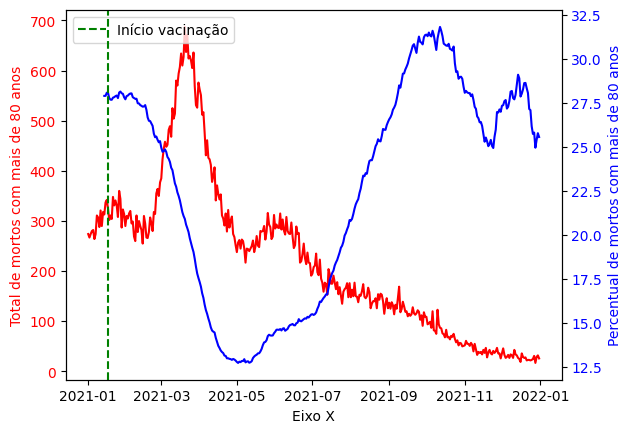

In [14]:
total_mortos_to_plot = []
for m80 in maior_80.NUM_MORTES:
    total_mortos_to_plot.append(m80)

fig, ax1 = plt.subplots()
ax1.plot(data_to_plot, total_mortos_to_plot, color='red')
ax1.set_xlabel('Eixo X')
ax1.set_ylabel('Total de mortos com mais de 80 anos', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(data_to_plot, percentual_to_plot, color='blue')
ax2.set_ylabel('Percentual de mortos com mais de 80 anos', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

data_vertical = pd.Timestamp('2021-01-17')
plt.axvline(x=data_vertical, color='green', linestyle='--', label='Início vacinação')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


plt.show()

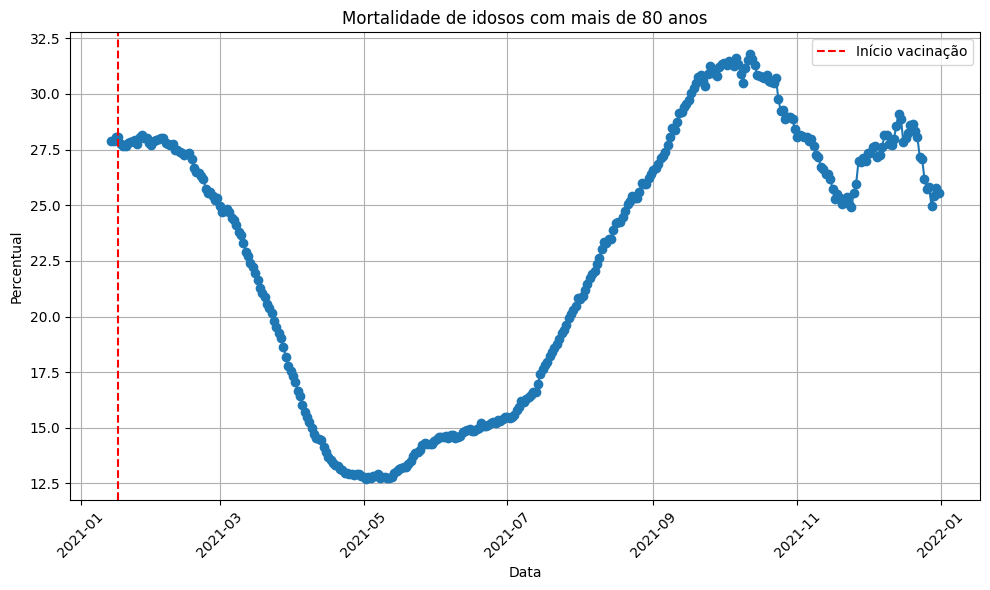

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(data_to_plot[2:], percentual_to_plot[2:], marker='o', linestyle='-')

plt.xlabel('Data')
plt.ylabel('Percentual')
plt.title('Mortalidade de idosos com mais de 80 anos')

data_vertical = pd.Timestamp('2021-01-17')
plt.axvline(x=data_vertical, color='red', linestyle='--', label='Início vacinação')
plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
filtro_idade = mortes_covid[(mortes_covid['IDADE'] >= 70) & (mortes_covid['IDADE'] < 80)]

maior_70 = filtro_idade.groupby('DTOBITO')['IDADE'].size().rename('NUM_MORTES').to_frame()
maior_70['MEDIA_MOVEL'] = maior_70['NUM_MORTES'].rolling(window=14).mean()

print(maior_70)

            NUM_MORTES  MEDIA_MOVEL
DTOBITO                            
2021-01-01         249          NaN
2021-01-02         289          NaN
2021-01-03         283          NaN
2021-01-04         262          NaN
2021-01-05         275          NaN
...                ...          ...
2021-12-27          22    26.428571
2021-12-28          23    26.500000
2021-12-29          21    25.928571
2021-12-30          25    25.857143
2021-12-31          22    25.000000

[365 rows x 2 columns]


In [17]:
data_to_plot = []
percentual_to_plot = []
window_size = 3

for index, todos, m70 in zip(mortalidade_dia.index, mortalidade_dia.MEDIA_MOVEL, maior_70.MEDIA_MOVEL):
    percentual = (m70 * 100) / todos
    data_to_plot.append(index)
    percentual_to_plot.append(percentual)


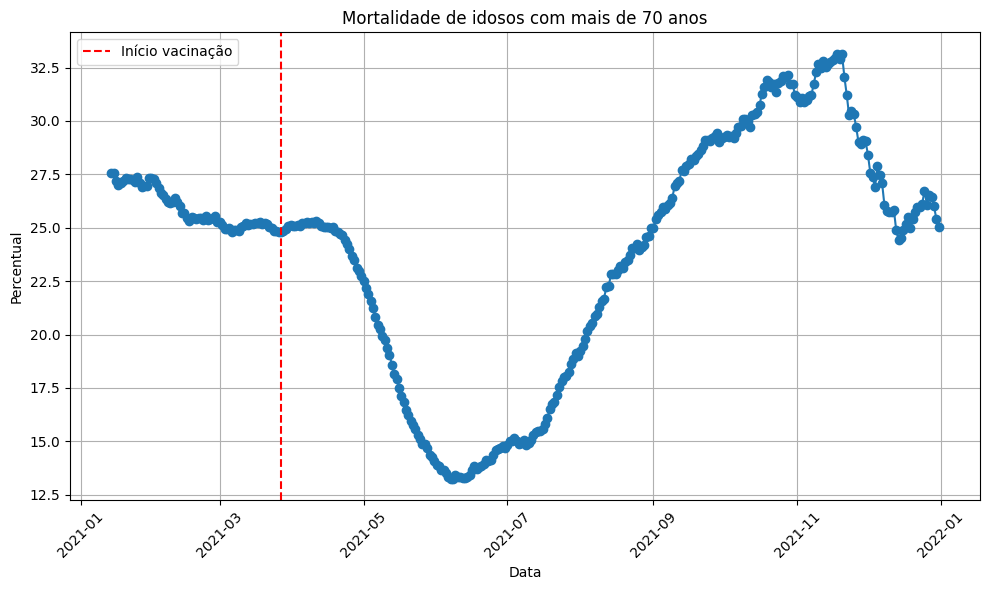

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(data_to_plot[2:], percentual_to_plot[2:], marker='o', linestyle='-')

plt.xlabel('Data')
plt.ylabel('Percentual')
plt.title('Mortalidade de idosos com mais de 70 anos')

data_vertical = pd.Timestamp('2021-03-27')
plt.axvline(x=data_vertical, color='red', linestyle='--', label='Início vacinação')
plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

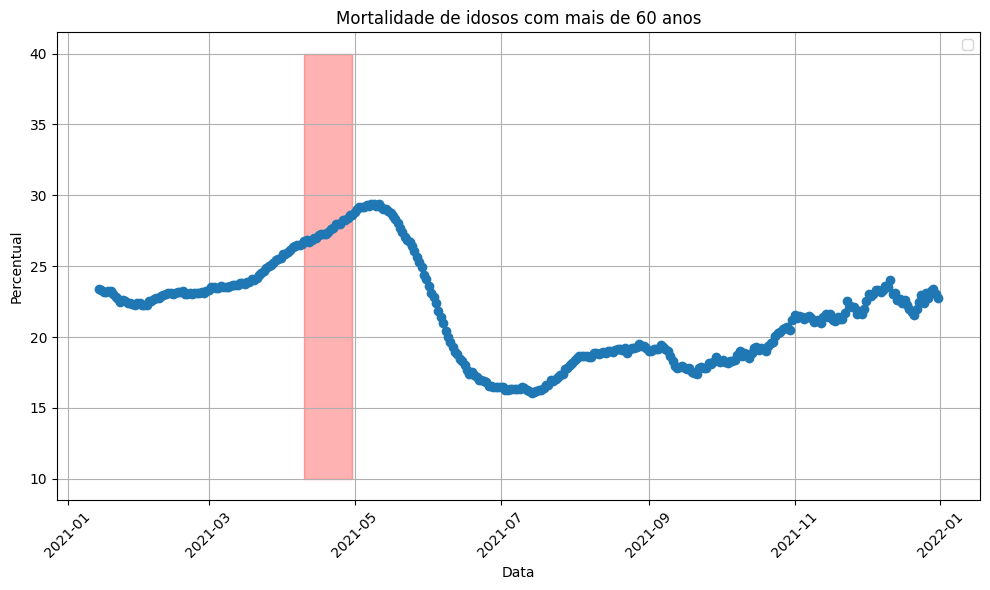

In [19]:
#FALTANDO DATA VACINACAO
filtro_idade = mortes_covid[(mortes_covid['IDADE'] >= 60) & (mortes_covid['IDADE'] < 70)]

maior_60 = filtro_idade.groupby('DTOBITO')['IDADE'].size().rename('NUM_MORTES').to_frame()
maior_60['MEDIA_MOVEL'] = maior_60['NUM_MORTES'].rolling(window=14).mean()

data_to_plot = []
percentual_to_plot = []
window_size = 3

for index, todos, m60 in zip(mortalidade_dia.index, mortalidade_dia.MEDIA_MOVEL, maior_60.MEDIA_MOVEL):
    percentual = (m60 * 100) / todos
    data_to_plot.append(index)
    percentual_to_plot.append(percentual)


plt.figure(figsize=(10, 6))
plt.plot(data_to_plot[2:], percentual_to_plot[2:], marker='o', linestyle='-')

plt.xlabel('Data')
plt.ylabel('Percentual')
plt.title('Mortalidade de idosos com mais de 60 anos')

y_bottom = 10
y_top = 40
plt.fill_betweenx([y_bottom, y_top], pd.Timestamp('2021-04-10'), pd.Timestamp('2021-04-30'), color='red', alpha=0.3)

plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


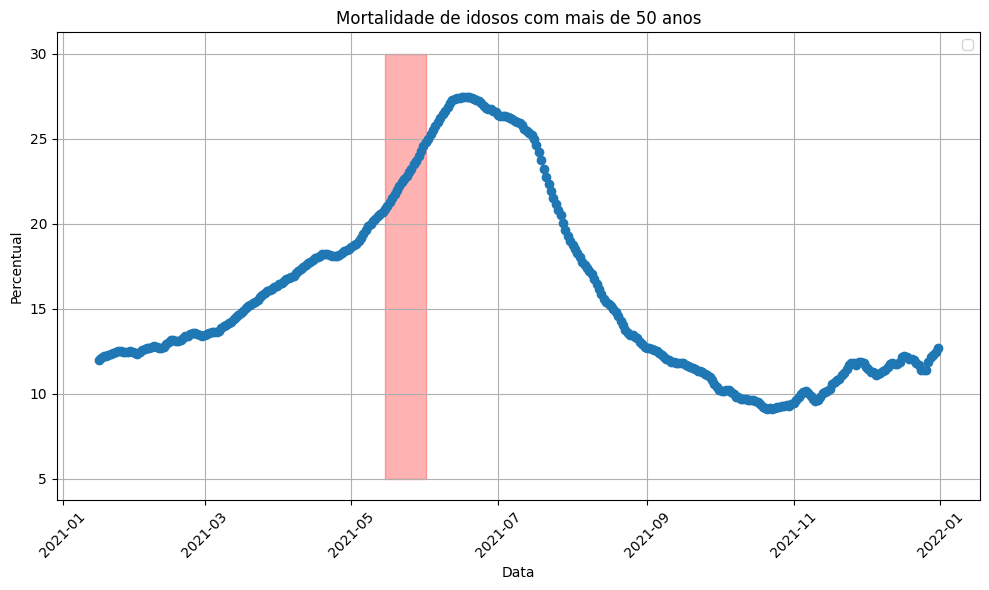

In [20]:
#FALTANDO DATA VACINACAO
filtro_idade = mortes_covid[(mortes_covid['IDADE'] >= 50) & (mortes_covid['IDADE'] < 60)]

maior_50 = filtro_idade.groupby('DTOBITO')['IDADE'].size().rename('NUM_MORTES').to_frame()
maior_50['MEDIA_MOVEL'] = maior_50['NUM_MORTES'].rolling(window=14).mean()


data_to_plot = []
percentual_to_plot = []
window_size = 3

for index, todos, m50 in zip(mortalidade_dia.index, mortalidade_dia.MEDIA_MOVEL, maior_50.MEDIA_MOVEL):
    percentual = (m50 * 100) / todos
    data_to_plot.append(index)
    percentual_to_plot.append(percentual)

smothed_percentual_to_plot = np.convolve(percentual_to_plot, np.ones(window_size)/window_size, mode='full')[:len(percentual_to_plot)]

plt.figure(figsize=(10, 6))
plt.plot(data_to_plot[2:], smothed_percentual_to_plot[2:], marker='o', linestyle='-')

plt.xlabel('Data')
plt.ylabel('Percentual')
plt.title('Mortalidade de idosos com mais de 50 anos')

y_bottom = 5
y_top = 30
plt.fill_betweenx([y_bottom, y_top], pd.Timestamp('2021-05-15'), pd.Timestamp('2021-06-01'), color='red', alpha=0.3)
plt.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
